In [ ]:
#Imports
import os
from google.colab import drive
from PIL import Image
import os
from pathlib import Path
from google.auth.transport.requests import AuthorizedSession
from google.oauth2 import service_account
from pprint import pprint
import json
import ee
from IPython.display import Image

In [ ]:
# INSERT YOUR PROJECT HERE
PROJECT = 'objectdet0'

!gcloud auth login --project {PROJECT}

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=741UIDBAxF2MomQpOImKpWbHCPIAO3&prompt=consent&access_type=offline&code_challenge=G3WB7tE8MpjEPpO_ckqqIxE7vc5dYoyhZCXRklXImMY&code_challenge_method=S256

Enter authorization code: 4/0AVHEtk5MbMggU3tjPVbmaGxU7OjLsNY9fbHFX4JbR8J424WvS66J85AHwWrhqs0O-j-WVw

You are now logged in as [suzzay19@gmail.com].
Your current project is [objectdet0].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [ ]:
# INSERT YOUR SERVICE ACCOUNT HERE
SERVICE_ACCOUNT='sujay-gcp@objectdet0.iam.gserviceaccount.com'
KEY = 'key.json'

!gcloud iam service-accounts keys create {KEY} --iam-account {SERVICE_ACCOUNT}

created key [d455d9b19bc9e588f3b2ff88e5bb8d142565c753] of type [json] as [key.json] for [sujay-gcp@objectdet0.iam.gserviceaccount.com]


In [ ]:
from google.auth.transport.requests import AuthorizedSession
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(KEY)
scoped_credentials = credentials.with_scopes(
    ['https://www.googleapis.com/auth/cloud-platform'])

session = AuthorizedSession(scoped_credentials)

url = 'https://earthengine.googleapis.com/v1beta/projects/earthengine-public/assets/LANDSAT'

response = session.get(url)

from pprint import pprint
import json
pprint(json.loads(response.content))

{'id': 'LANDSAT',
 'name': 'projects/earthengine-public/assets/LANDSAT',
 'type': 'FOLDER'}


In [ ]:
import ee

# Get some new credentials since the other ones are cloud scope.
ee_creds = ee.ServiceAccountCredentials(SERVICE_ACCOUNT, KEY)
ee.Initialize(ee_creds)

In [ ]:
coords = [
  -121.58626826832939, 
  38.059141484827485,
]
region = ee.Geometry.Point(coords)

collection = ee.ImageCollection('COPERNICUS/S2')
collection = collection.filterBounds(region)
collection = collection.filterDate('2020-04-01', '2020-09-01')
image = collection.median()

In [ ]:
serialized = ee.serializer.encode(image)

In [ ]:
# Make a projection to discover the scale in degrees.
proj = ee.Projection('EPSG:4326').atScale(10).getInfo()

# Get scales out of the transform.
scale_x = proj['transform'][0]
scale_y = -proj['transform'][4]

In [ ]:


url = 'https://earthengine.googleapis.com/v1beta/projects/{}/image:computePixels'
url = url.format(PROJECT)

response = session.post(
  url=url,
  data=json.dumps({
    'expression': serialized,
    'fileFormat': 'PNG',
    'bandIds': ['B4','B3','B2'],
    'grid': {
      'dimensions': {
        'width': 256,
        'height': 256
      },
      'affineTransform': {
        'scaleX': scale_x,
        'shearX': 0,
        'translateX': coords[0],
        'shearY': 0,
        'scaleY': scale_y,
        'translateY': coords[1]
      },
      'crsCode': 'EPSG:4326',
    },
    'visualizationOptions': {'ranges': [{'min': 0, 'max': 3000}]},
  })
)

image_content = response.content

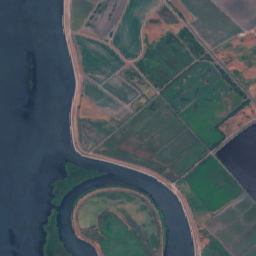

In [ ]:
# Import the Image function from the IPython.display module. 
Image(image_content)

In [ ]:
drive.mount('/content/drive')
path = r"/content/drive/MyDrive/model_test/images"
os.chdir(path)
with open(path+"/image.png", "wb") as img:
    img.write(image_content)

Mounted at /content/drive
